# Identify Peaks by Derivative

In [1]:
# For synthetic data to check uncertainties

In [2]:
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib
import random
from math import pi, exp

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

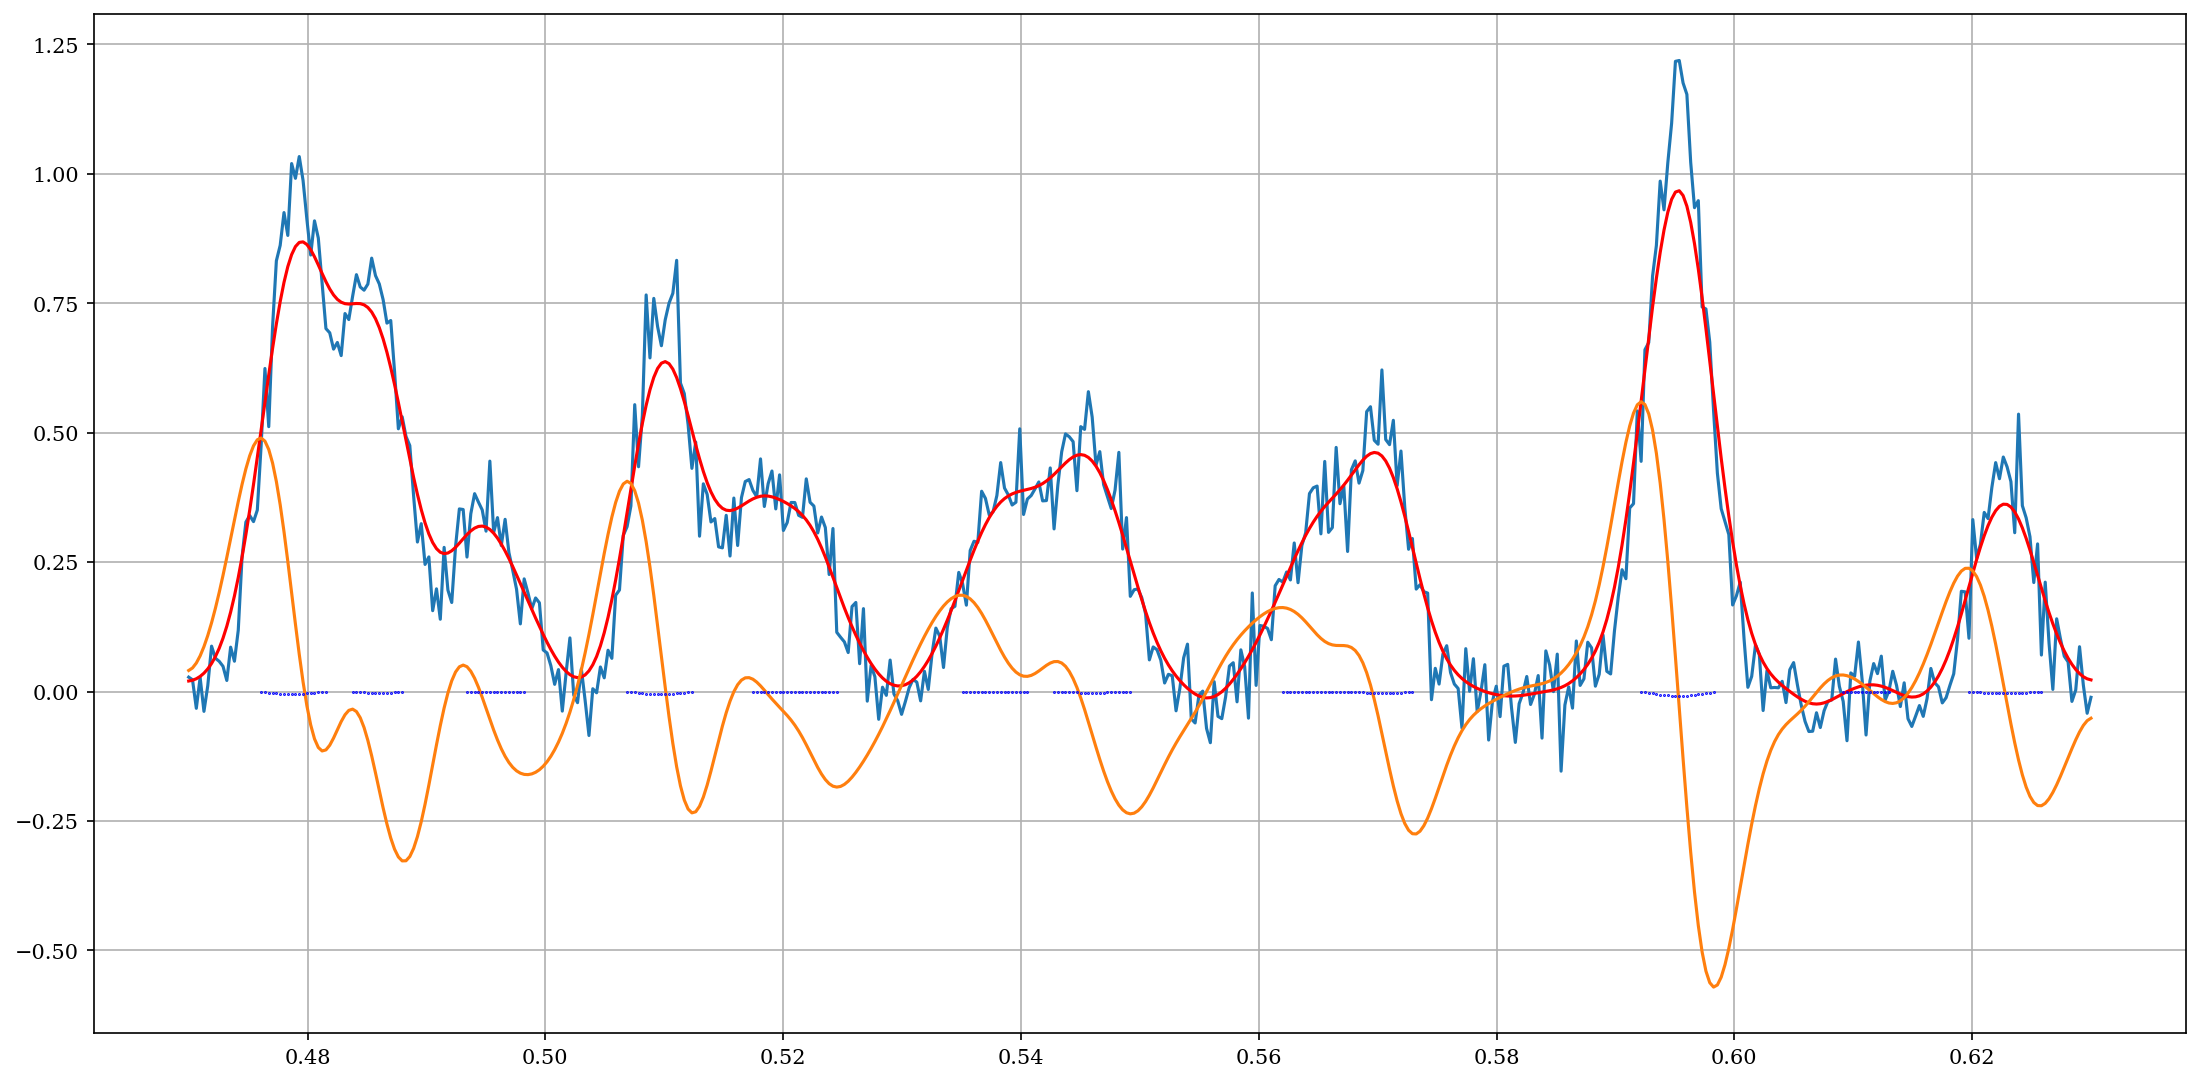

In [11]:
# Synthesize data with gaussian noise
%matplotlib inline

bounds = (.47, .63)
n_peaks = random.randrange(10, 25) # Number of peaks 
pos = [random.uniform(bounds[0], bounds[1]) for i in range(n_peaks)] # True line wavenumbers
amp = [random.uniform(0.5, .3) for i in range(n_peaks)] # True peak amplitudes
sig = [random.uniform(.002, .003) for i in range(n_peaks)] # True peak sigmas - doppler sigma ~ .0025

res = 500
k = np.linspace(bounds[0], bounds[1], res)
a = np.zeros(res)
for i in range(len(k)):
    for n in range(n_peaks):
        a[i] += amp[n] * exp(-(1/2)*((k[i]-pos[n])/sig[n])**2)
        
a += np.random.normal(0, .05, res) # Add gaussian noise
a_nosmooth = a

# Smooth data, take derivative, smooth derivative, take derivative, smooth derivative

a = gaussian_filter1d(a_nosmooth, 5)

#a = savgol_filter(a_nosmooth, 33, 3)
da = gaussian_filter1d(np.gradient(a), 3)
#da = savgol_filter(da, 5, 1)
dda = gaussian_filter1d(np.gradient(da), 3)
#dda = savgol_filter(dda, 25, 3)

fig, ax = plt.subplots(figsize=(18, 9),dpi=150)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'font.family': 'serif'})

ax.plot(k, a_nosmooth)
ax.plot(k, a, 'r-')
ax.plot(k, da*10, markersize=.5)
ax.plot(k[dda<0], dda[dda<0], 'bo', markersize=.4)
ax.grid(True)
plt.show()

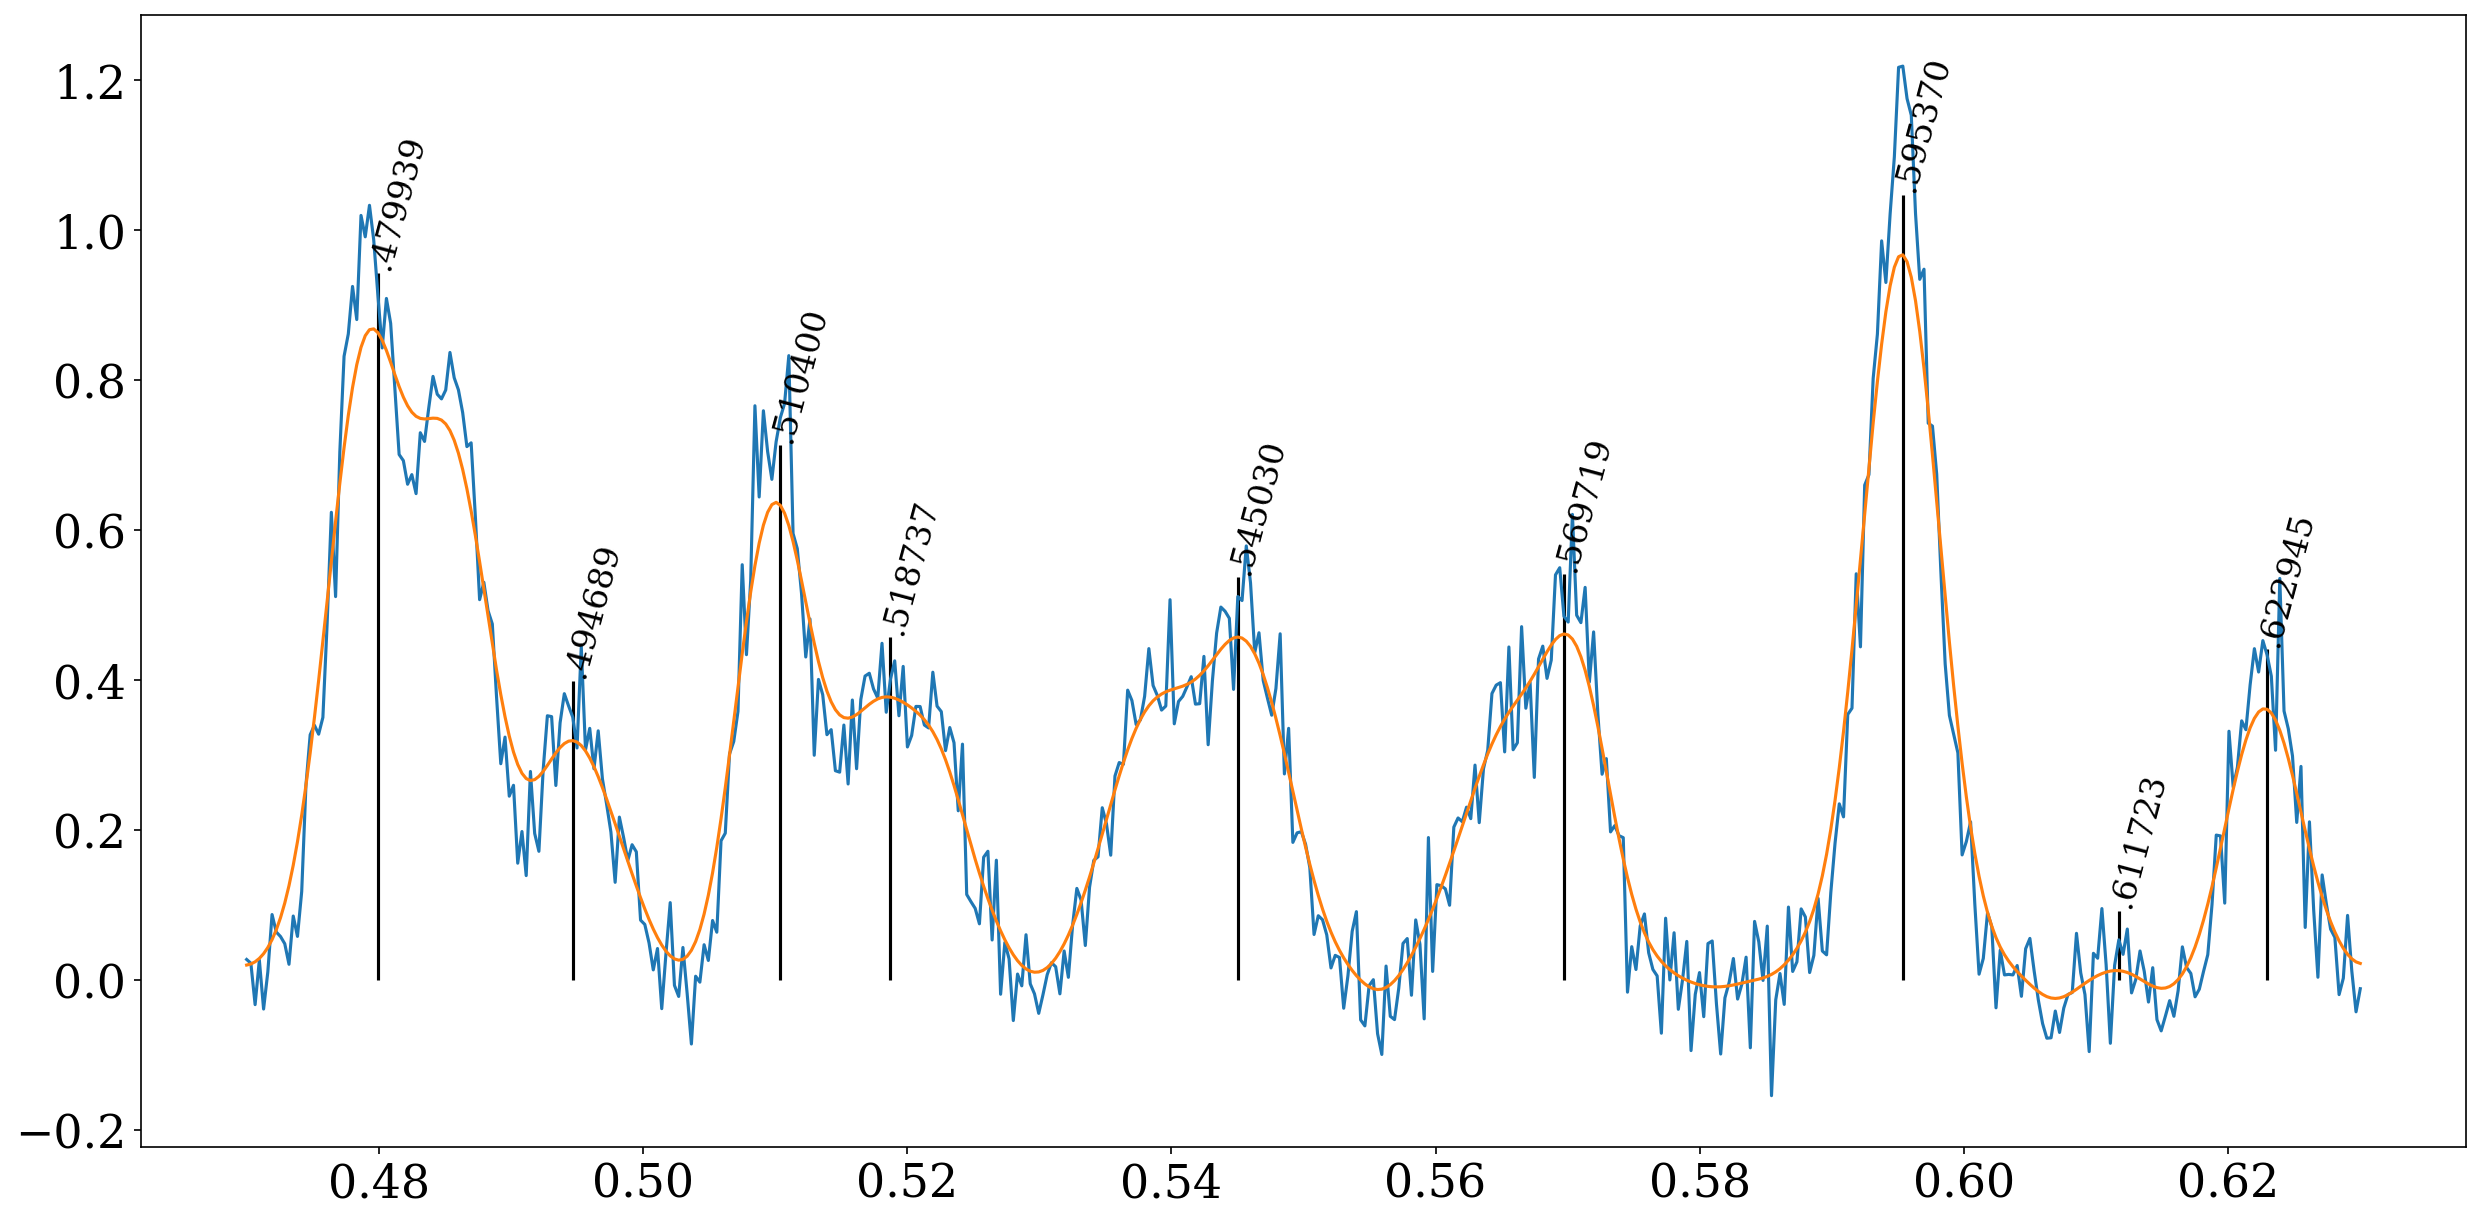

Line wavelengths: 0.479939879759519, 0.494689378757515, 0.5104008016032064, 0.5187374749498997, 0.5450300601202405, 0.5697194388777556, 0.5953707414829659, 0.6117234468937875, 0.6229458917835672
Line widths: 


In [12]:
# Find peaks
threshold = .005 # Minimum height of peak
peaks1 = [] # Pretty sure there are peaks here (da goes from + to -)
peaks2 = [] # Not as sure there are peaks here (less sensitive condition: dda < 0)

for i in range(1, len(a)):
    if da[i-1]>0 and da[i]<0 and a[i]>threshold:
        peaks1.append(i)
    if dda[i] < 0 and a[i]>threshold:
        peaks2.append(i)
        
# Average nearby peak locations (could maybe get width from this) (only needed for peaks2)
runs = [[]]
for i in range(1,len(peaks2)):
    if peaks2[i] <= peaks2[i-1]+8:
        runs[-1].append(peaks2[i])
    else:
        runs.append([])
        runs[-1].append(peaks2[i])
        
# Remove runs containing a certain peak1
runs2 = []
for run in runs:
    if set(peaks1).isdisjoint(run) and not run in runs2:
        runs2.append(run)
runs = runs2

peaks2 = [int(mean(run)) for run in runs]
peaks = peaks1 + peaks2

peak_widths = [.5*len(run)*(k[1]-k[0]) for run in runs] #Some ill-defined measure of uncertainty/width. Currently not used

k_peaks1 = k[peaks1]
k_peaks2 = k[peaks2]
k_peaks = k[peaks]

# Plot location and values of lines
fig, ax = plt.subplots(figsize=(20, 10),dpi=150)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'font.family': 'serif'})

h = .22
ax.plot(k, a_nosmooth)
ax.plot(k, a)
for i in range(len(peaks1)):
    ax.vlines(k[peaks1[i]], 0, a[peaks1[i]]+.08)
    ax.text(k[peaks1[i]]-.001, 
            a[peaks1[i]]+.08, str(k[peaks1[i]]-int(k[0]))[1:8], 
            fontsize=16, rotation=75, va='bottom')
for i in range(len(peaks2)):
    ax.vlines(k[peaks2[i]], 0, a[peaks2[i]]+.08, linestyle='--')
    ax.text(k[peaks2[i]]-.001, 
            a[peaks2[i]]+.08, str(k[peaks2[i]]-int(k[0]))[1:8], 
            fontsize=16, rotation=75, va='bottom')
plt.show()

# Print the first 10 line to compare with Nick
print("Line wavelengths: " + ', '.join(map(str,k_peaks[:10]-int(k_peaks[0]))))
print("Line widths: " + ', '.join(map(str,peak_widths[:10])))  #Not used, should figure out how to do uncertainties

# Dataphile Fitting

In [13]:
# Generate model creator string
creator_string = ''

for i in peaks:
    print(k[i],a_nosmooth[i])
    creator_string += "Model(gaussian1D, Parameter(value={amplitude}, bounds=(0, 1),  label='amplitude'), Parameter(value={location}, bounds=(min(k), max(k)), label='center'),Parameter(value=.0025,  bounds=(.001, .003), label='width'), label='feature_{index}'),".format(location=k[i], amplitude=a[i], index=peaks.index(i))
creator_string += "label='gaussian_peaks')"
creator_string = "model = CompositeModel(" + creator_string


0.479939879759519 0.9123909809843436
0.494689378757515 0.3507444928673916
0.5104008016032064 0.7501684911120461
0.5187374749498997 0.4015466144553637
0.5450300601202405 0.5117081800467735
0.5697194388777556 0.48534040801390615
0.5953707414829659 1.2189061057899049
0.6117234468937875 0.05404940462429034
0.6229458917835672 0.4339382616573365


<IPython.core.display.Javascript object>


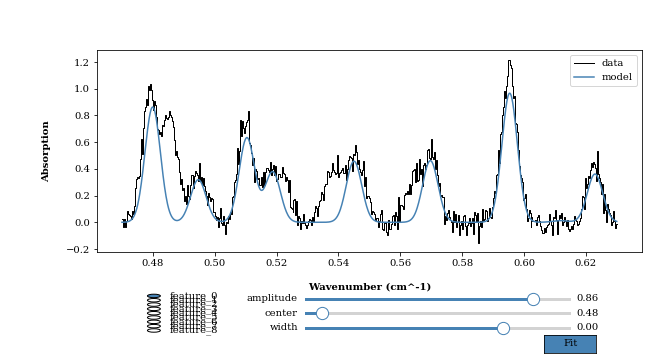

In [15]:
from dataphile.datasets import SyntheticDataset
from dataphile.statistics.distributions import gaussian1D, polynomial1D
from dataphile.statistics.regression.modeling import Parameter, Model, CompositeModel, AutoGUI
from matplotlib import patches
#plt.style.use('seaborn-notebook')
%matplotlib notebook

figure = plt.figure('Absorption Data', figsize=(9, 5))

# create main plot of data
ax_1 = figure.add_axes([0.15, 0.14, 0.84, 0.70])
data_graph, = ax_1.step(k, a_nosmooth, color='black', lw=1, label='data')

# labels
ax_1.set_ylabel('Absorption', labelpad=15, fontweight='semibold')
ax_1.set_xlabel('Wavenumber (cm^-1)', labelpad=15, fontweight='semibold')


# overlay small markers showing location of features
#loc, yloc = x0_s, [(bias + peak).max() + 25 for peak in peaks]
#markers = ax_2.scatter(xloc, yloc, marker='v', color='steelblue')

exec(creator_string)

xsample = np.linspace(min(k), max(k), 1000)
model_graph, = ax_1.plot(xsample, model(xsample), color='steelblue', label='model')
ax_1.legend();

ax_1.set_position([0.15, 0.30, 0.84, 0.56])
gui = AutoGUI(model, [model_graph], bbox=[0.20, 0.07, 0.75, 0.12], figure=figure,
              slider_options={'color': 'steelblue'}, data=(k, a_nosmooth));


In [9]:
print(amp, pos, sig)
model.summary()

[0.49972565082139697] [0.5216117355068037] [0.002433055928766927]


value   uncertainty
model     parameter                        
feature_0 amplitude  0.499726  1.455656e-18
          center     0.521612  8.183679e-21
          width      0.002433  8.183679e-21

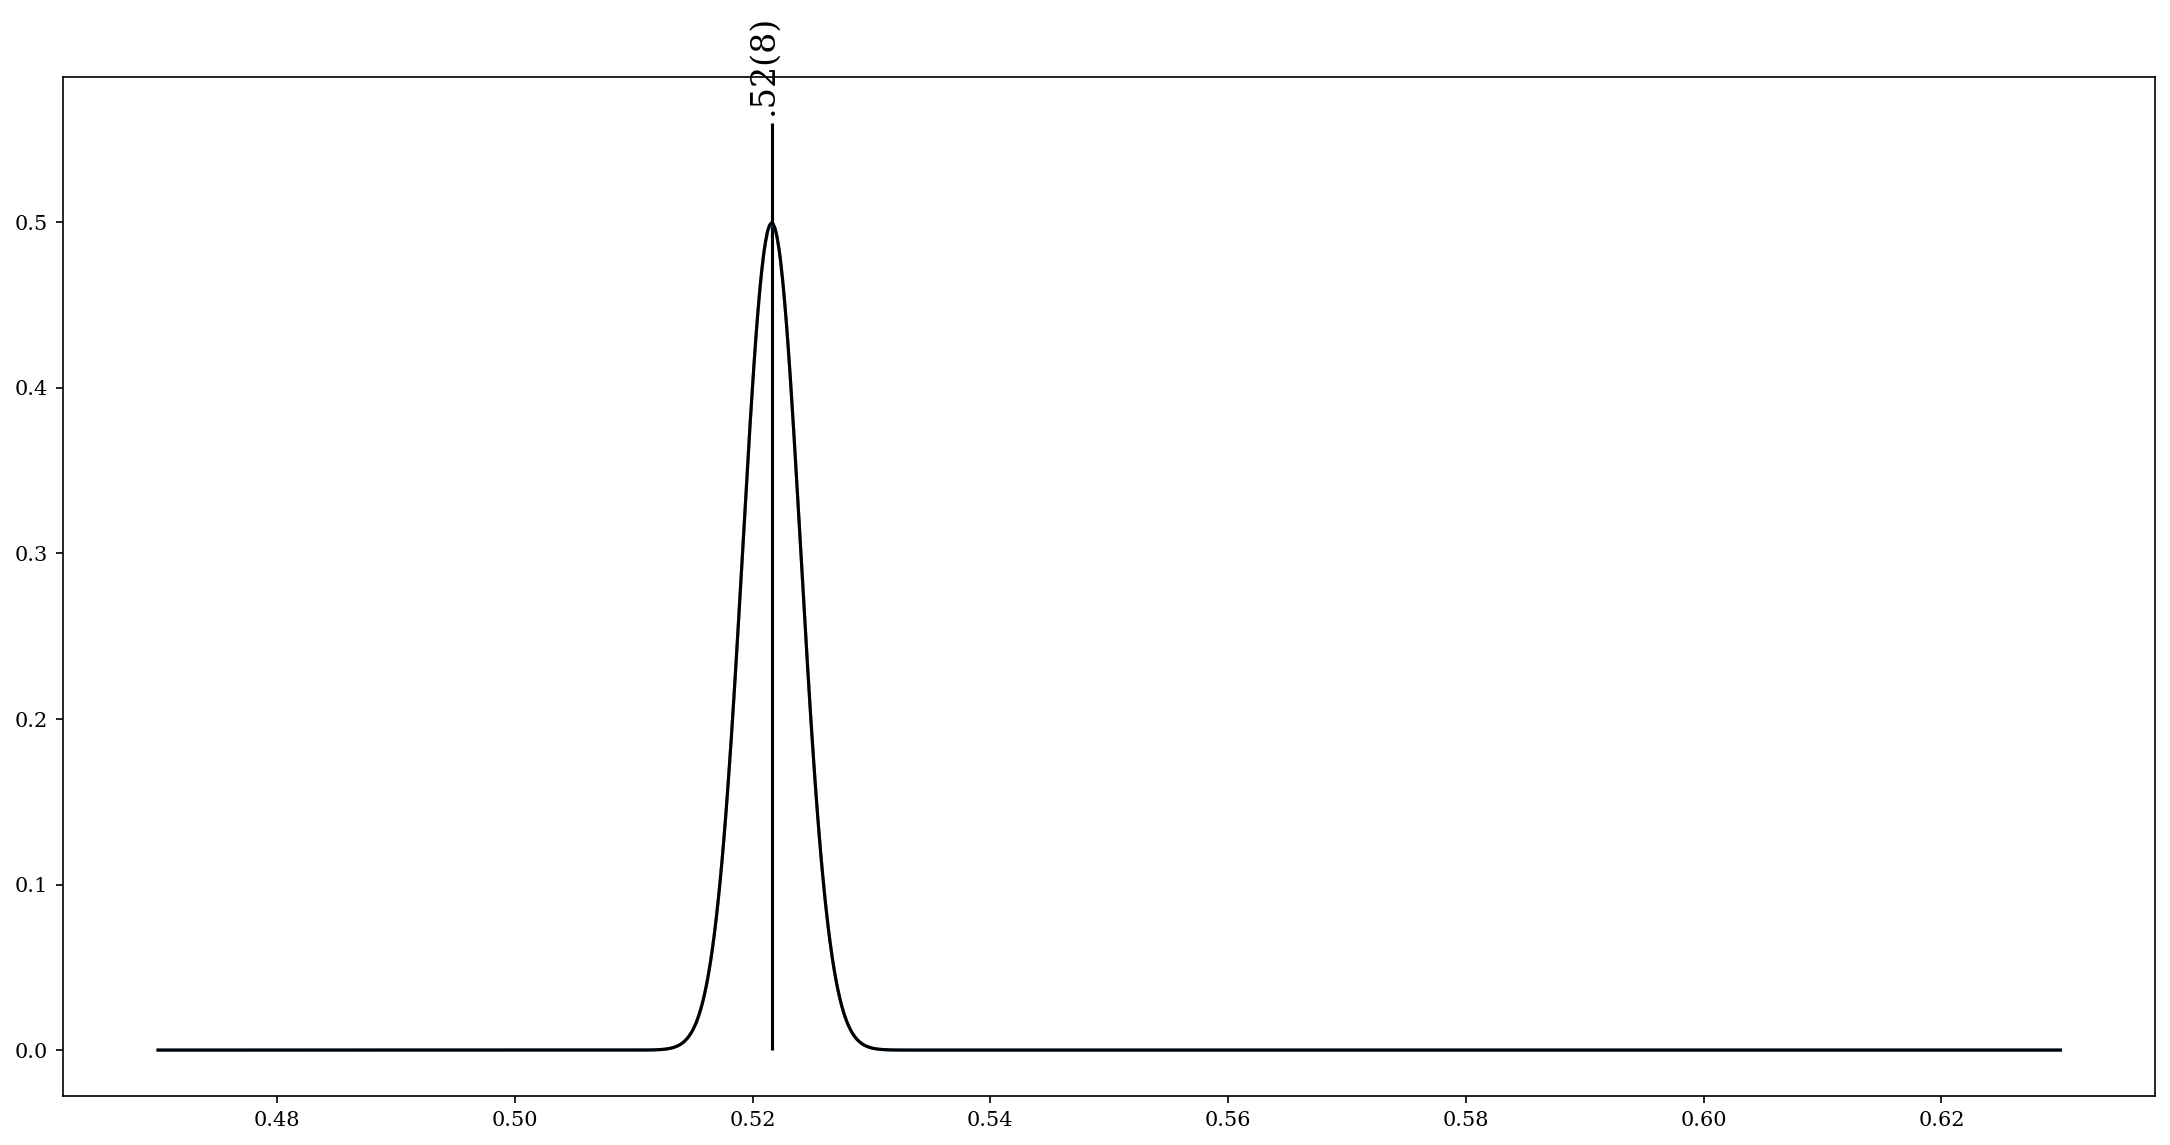

In [10]:
values0 = np.array([i.values for i in model.models])
uncerts0 = np.array([i.uncertainties for i in model.models])
#values = values0[uncerts0[:,0]/values0[:,0]<.1] # Only take models with fractional amplitude uncertainty < 10 %
#uncerts = uncerts0[uncerts0[:,0]/values0[:,0]<.1] # Could also just take the ones with amplitude above threshold

threshold = .012

values = values0[values0[:,0]>threshold]
uncerts = uncerts0[values0[:,0]>threshold]


%matplotlib inline

amplitudes = values[0:,0]
k_peaks = values[0:,1]
d_k_peaks = uncerts[0:,1]


fig, ax = plt.subplots(figsize=(18, 9),dpi=150)


ax.plot(k, a_nosmooth, alpha=.7)
h = .06

# Plot location and values of lines
for i in range(len(k_peaks)):    
    ax.vlines(k_peaks[i], 0, amplitudes[i]+h)
    
    if 'e' in str(d_k_peaks[i]):
        n = int(str(d_k_peaks[i])[-1]) - 1
        
        if int(str(d_k_peaks[i])[2]) < 5:
            ax.text(k_peaks[i]-.002, 
                amplitudes[i]+h+.005, str(k_peaks[i]-int(k[0]))[1:n+4]+'('+str(d_k_peaks[i])[0]+')', 
                fontsize=16, rotation=90, va='bottom')
            
        else:
            ax.text(k_peaks[i]-.002, 
                amplitudes[i]+h+.005, str(k_peaks[i]-int(k[0]))[1:n+4]+'('+str(int(str(d_k_peaks[i])[0])+1)+')', 
                fontsize=16, rotation=90, va='bottom')
    else:
        s = str(d_k_peaks[i])[2:]
        n = 0
        while s[0]=='0':
            s = s[1:]
            n += 1
            
        if int(str(d_k_peaks[i])[n+3]) < 5:
            ax.text(k_peaks[i]-.002, 
                amplitudes[i]+h+.005, str(k_peaks[i]-int(k[0]))[1:n+4]+'('+str(d_k_peaks[i])[n+2]+')', 
                fontsize=16, rotation=90, va='bottom')
        else:
            ax.text(k_peaks[i]-.002, 
                amplitudes[i]+h+.005, str(k_peaks[i]-int(k[0]))[1:n+4]+'('+str(int(str(d_k_peaks[i])[n+2])+1)+')', 
                fontsize=16, rotation=90, va='bottom')
            
model_graph, = ax.plot(xsample, model(xsample), color='black', label='model') #Plot fit
plt.show()

In [23]:
pos.sort()
print(pos)

[0.6055244947453717]
